In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec
import itertools
import operator
import numpy as np
import math
%matplotlib inline 
plt.ion()
#plt.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

plt.rcParams['axes.titlesize'] = 22



from time import time
import datetime

import sys
sys.path.append('../simulations/')
from grid_manager import *
from habitat_analysis import *
from hdf5_reader import *

## Landscape simulation function:

In [2]:
def perm_wall_sim(grid_shape = [30,60], Q=1, A=0.5, ww=3, wp=0.5, cw=[3,3], cp=[0.35,0.7]):
    # 1. initialize landscape
    n_rows,n_cols = grid_shape
    N = n_rows*n_cols
    qualities = np.ones((N,))*Q
    g = Grid(shape=grid_shape, qualities=qualities, nhood_size=8)
    g.A = A * g.A
    
    # 2. compute the wall
    wpt = int(math.floor(n_cols*wp)-math.ceil(ww/2))
    xs = range(wpt, wpt+ww)
     
    # 3. compute the corridors
    for i in range(len(cw)):
        cpt=int(math.floor(n_rows*cp[i])-math.floor(cw[i]/2.0))
        if i == 0:
            ys = range(cpt)
        else:
            ys=ys+range(max(ys)+1+cw[i-1], cpt)
    ys=ys+range(max(ys)+1+cw[i], n_rows)
    impossible_nodes = list(itertools.product(ys,xs))
    if len(impossible_nodes) > 0:
        g.set_impossible_nodes(impossible_nodes, impossible_affinity=0.0)
    return g

In [46]:
#affinity = 1.
affinity = 0.35
ia = 0. # IMPOSSIBLE AFFINITY
Q = 1.

height = 21
width = 41


lgs = []
lgs.append(perm_wall_sim(grid_shape = (height,width), Q=Q, A=affinity, ww=3, wp=0.5, cw=[3],  cp=[0.2]))
lgs.append(perm_wall_sim(grid_shape = (height,width), Q=Q, A=affinity, ww=3, wp=0.5, cw=[3,3],  cp=[0.2,0.8]))
# lgs.append(perm_wall_sim(grid_shape = [30,60], Q=Q, A=affinity, ww=5, wp=0.5, cw=[7,0], cp=[0.5,0.7])[0])
# lgs.append(perm_wall_sim(grid_shape = (31,61), Q=Q, A=affinity, ww=5, wp=0.5, cw=[0,0], cp=[0.5,0.7], ia=ia))


In [ ]:
s_y = 4
s_x = 5

t_y = height-8
t_x = width-10

../simulations/habitat_analysis.py:1181: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  I_W_t[t,:] = 0


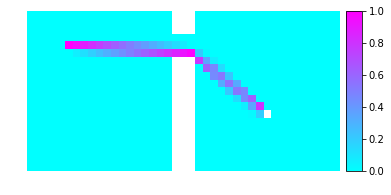

/anaconda3/envs/py2env/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


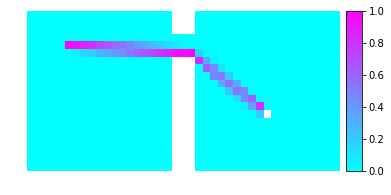

(<matplotlib.image.AxesImage at 0x1a1f31c050>,
 <matplotlib.colorbar.Colorbar at 0x10cb78850>)

In [4]:
G = lgs[0]
s = G.grid_coordinates_to_node_id((s_y,s_x))
t = G.grid_coordinates_to_node_id((t_y,t_x))


LC = HabitatAnalysis(G, \
                      beta = 15., \
                      symmetric = False, \
#                      landmarks = [s,t], \
                      similarity_measure='least_cost', \
                      affinity_to_cost='minus_log', \
                      distance_to_similarity='exp_minus', \
                      verbose=False)

bet_LC = LC.RSP_st_betweenness(sources = [s], destinations=[t], LC_approximation=True)

G.plot(bet_LC)

bet_LC_2 = LC.RSP_st_betweenness(sources = [s], destinations=[t])

G.plot(bet_LC_2)

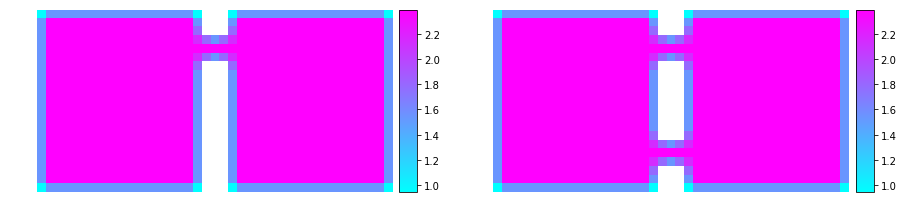

In [5]:
fig,axs = plt.subplots(1,2,figsize=(15,20))
lgs[0].plot_indegrees(ax = axs[0])
lgs[1].plot_indegrees(ax = axs[1])


In [114]:
import habitat_analysis
reload(habitat_analysis)
from habitat_analysis import *


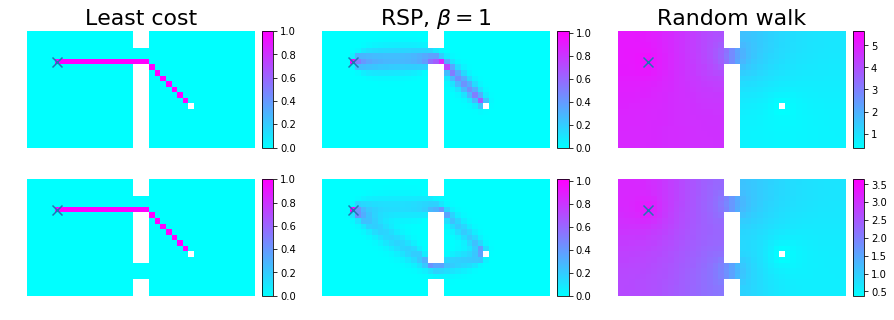

In [120]:


s_y = 5
s_x = 5

t_y = height-8
t_x = width-12

fig, axs = plt.subplots(2,3,figsize=(15,5))

for i_G,G in enumerate(lgs):
    s = G.grid_coordinates_to_node_id((s_y,s_x))
    t = G.grid_coordinates_to_node_id((t_y,t_x))


    LC = HabitatAnalysis(G, \
                          beta = 15., \
                          symmetric = False, \
    #                      landmarks = [s,t], \
                          similarity_measure='RSP_dissimilarity', \
                          affinity_to_cost='minus_log', \
                          distance_to_similarity='exp_minus', \
                          verbose=False)

    bet_LC = LC.RSP_st_betweenness(sources = [s], destinations=[t], LC_approximation=True)
    # bet_LC = bet_LC + 1e-9
    # bet_LC[s] = 0.
    bet_LC[t] = 0.

    
    RW = HabitatAnalysis(G, \
                          beta = 1e-9, \
                          symmetric = False, \
    #                      landmarks = [s,t], \
                          similarity_measure='RSP_dissimilarity', \
                          affinity_to_cost='minus_log', \
                          distance_to_similarity='exp_minus', \
                          verbose=False)


    bet_RW = RW.RSP_st_betweenness(sources = [s], destinations=[t])
    
    d_in = np.sum(G.A, axis=1).A.flatten()
    bet_RW_volt = np.divide(bet_RW, d_in)
    # bet_RW_volt -= bet_RW_volt[t]+0.0001
    
    bet_RW[s] = 0

    
    
    RSP = HabitatAnalysis(G, \
                          beta = 1., \
                          symmetric = False, \
    #                      landmarks = [s,t], \
                          similarity_measure='RSP_dissimilarity', \
                          affinity_to_cost='minus_log', \
                          distance_to_similarity='exp_minus', \
                          verbose=False)


    bet_RSP = RSP.RSP_st_betweenness(sources = [s], destinations=[t])
    # bet_RSP[s] = 0

    if i_G == 0:
        G.plot(bet_LC,  ax = axs[i_G,0], title=r"Least cost", source=(s_x,s_y))
        G.plot(bet_RSP, ax = axs[i_G,1], title=r"RSP, $\beta=1$", source=(s_x,s_y))
        G.plot(bet_RW_volt,  ax = axs[i_G,2], title=r"Random walk", source=(s_x,s_y))
    else:
        G.plot(bet_LC,  ax = axs[i_G,0], source=(s_x,s_y))
        G.plot(bet_RSP, ax = axs[i_G,1], source=(s_x,s_y))
        G.plot(bet_RW_volt,  ax = axs[i_G,2], source=(s_x,s_y))
        


In [7]:
# fig.savefig("corridor_betweenness_st.pdf", bbox_inches='tight')

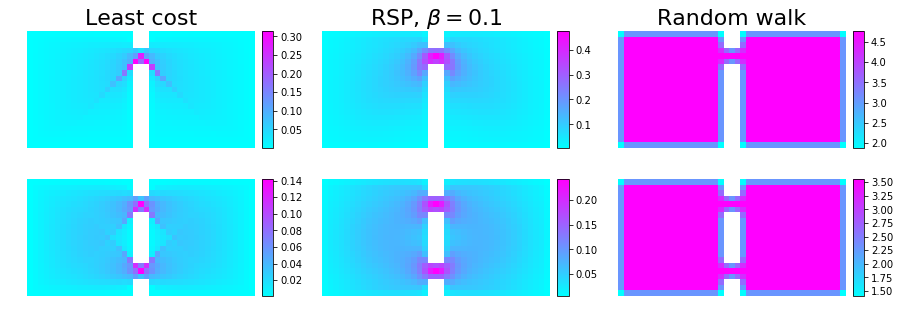

In [12]:


s_y = 5
s_x = 5

t_y = height-8
t_x = width-12

fig, axs = plt.subplots(2,3,figsize=(15,5))

for i_G,G in enumerate(lgs):
    s = G.grid_coordinates_to_node_id((s_y,s_x))
    t = G.grid_coordinates_to_node_id((t_y,t_x))


    LC = HabitatAnalysis(G, \
                          beta = 15., \
                          symmetric = False, \
    #                      landmarks = [s,t], \
                          similarity_measure='RSP_dissimilarity', \
                          affinity_to_cost='minus_log', \
                          distance_to_similarity='exp_minus', \
                          verbose=False)

    bet_LC = LC.RSP_full_betweenness(LC_approximation=True)
    # bet_LC = bet_LC + 1e-9
    
    RW = HabitatAnalysis(G, \
                          beta = 1e-9, \
                          symmetric = False, \
    #                      landmarks = [s,t], \
                          similarity_measure='RSP_dissimilarity', \
                          affinity_to_cost='minus_log', \
                          distance_to_similarity='exp_minus', \
                          verbose=False)


    bet_RW = RW.RSP_full_betweenness()

    
    
    RSP = HabitatAnalysis(G, \
                          beta = .1, \
                          symmetric = False, \
    #                      landmarks = [s,t], \
                          similarity_measure='RSP_dissimilarity', \
                          affinity_to_cost='minus_log', \
                          distance_to_similarity='exp_minus', \
                          verbose=False)


    bet_RSP = RSP.RSP_full_betweenness()

    bet_LC  = bet_LC  / (G.N**2)
    bet_RW  = bet_RW  / (G.N**2)
    bet_RSP = bet_RSP / (G.N**2)
    
    if i_G == 0:
        G.plot(bet_LC,  ax = axs[i_G,0], title=r"Least cost")
        G.plot(bet_RSP, ax = axs[i_G,1], title=r"RSP, $\beta=0.1$")
        G.plot(bet_RW,  ax = axs[i_G,2], title=r"Random walk")
    else:
        G.plot(bet_LC,  ax = axs[i_G,0])
        G.plot(bet_RSP, ax = axs[i_G,1])
        G.plot(bet_RW,  ax = axs[i_G,2])
        


In [13]:
# fig.savefig("corridor_betweenness.pdf", bbox_inches='tight')

In [45]:
import habitat_analysis
from habitat_analysis import *
reload(habitat_analysis)

<module 'habitat_analysis' from '../simulations/habitat_analysis.py'>

(<matplotlib.image.AxesImage at 0x1a30e95cd0>,
 <matplotlib.colorbar.Colorbar at 0x1a30eccb90>)

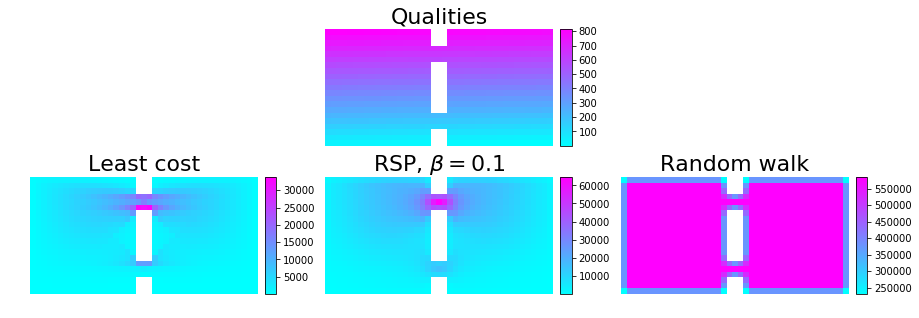

In [66]:
import networkx as nx

fig, axs = plt.subplots(2,3,figsize=(15,5))

axs[0,0].axis("off")
axs[0,2].axis("off")

G = lgs[1]
s = G.grid_coordinates_to_node_id((s_y,s_x))
t = G.grid_coordinates_to_node_id((t_y,t_x))

G.qualities = np.matrix(np.arange(G.N, 0, -1)).T
G.source_qualities = G.qualities.copy()
G.target_qualities = G.qualities.copy()

#G.source_qualities = np.matrix(np.ones(G.N)).T
#G.target_qualities = np.matrix(np.ones(G.N)).T

G.plot(G.qualities, ax = axs[0,1], title="Qualities")


LC = HabitatAnalysis(G, \
                      beta = 12., \
                      symmetric = False, \
#                      landmarks = [s,t], \
                      similarity_measure='RSP_dissimilarity', \
                      affinity_to_cost='minus_log', \
                      distance_to_similarity='exp_minus', \
                      verbose=False)

bet_LC = LC.RSP_full_betweenness_qweighted(LC_approximation=True)
# bet_LC = bet_LC + 1e-9

RW = HabitatAnalysis(G, \
                      beta = 1e-9, \
                      symmetric = False, \
#                      landmarks = [s,t], \
                      similarity_measure='RSP_dissimilarity', \
                      affinity_to_cost='minus_log', \
                      distance_to_similarity='exp_minus', \
                      verbose=False)


bet_RW = RW.RSP_full_betweenness_qweighted()



RSP = HabitatAnalysis(G, \
                      beta = .1, \
                      symmetric = False, \
#                      landmarks = [s,t], \
                      similarity_measure='RSP_dissimilarity', \
                      affinity_to_cost='minus_log', \
                      distance_to_similarity='exp_minus', \
                      verbose=False)


bet_RSP = RSP.RSP_full_betweenness_qweighted()

bet_LC  = bet_LC  / (G.N**2)
bet_RW  = bet_RW  / (G.N**2)
bet_RSP = bet_RSP / (G.N**2)

G.plot(bet_LC,  ax = axs[1,0], title=r"Least cost")
G.plot(bet_RSP, ax = axs[1,1], title=r"RSP, $\beta=0.1$")
G.plot(bet_RW,  ax = axs[1,2], title=r"Random walk")
        


In [69]:
fig.savefig("corridor_qbetweenness.pdf", bbox_inches="tight")